In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import Counter
from scipy.optimize import curve_fit
import os
import sys
sys.path.append(os.path.abspath("../../shared"))  # Agrega la carpeta al PYTHONPATH
from tokenizer_v2 import tokenizer, loadFileStopWords
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pitta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
STOP_WORDS_FILE = '../../shared/stop-words.txt'
URL_QUIJOTE = "http://www.gutenberg.org/cache/epub/2000/pg2000.txt"
response = requests.get(URL_QUIJOTE)
book_content = response.text

In [4]:
# Obtener la lista de términos y sus frecuencias
terms = tokenizer(book_content)
term_freq = Counter(terms)
sorted_term_freq = sorted(term_freq.items(), key=lambda x: x[1], reverse=True)
frequencies = [freq for term, freq in sorted_term_freq]

# Calcular el rango de los datos para el ajuste
rank = np.arange(1, len(frequencies) + 1)
# Ajustar la curva utilizando Polyfit
log_frequencies = np.log(frequencies)
log_rank = np.log(rank)
coefficients = np.polyfit(log_rank, log_frequencies, 1)
fit = np.poly1d(coefficients)

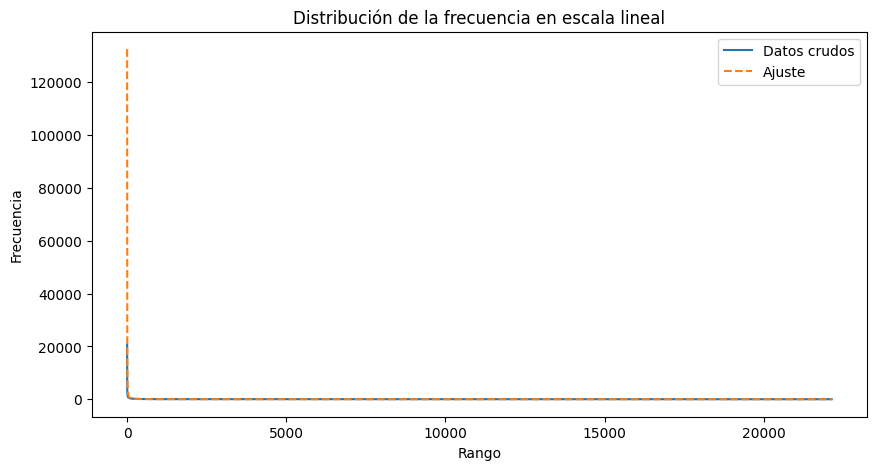

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(rank, frequencies, label='Datos crudos')
plt.plot(rank, np.exp(fit(log_rank)), label='Ajuste', linestyle='--')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.title('Distribución de la frecuencia en escala lineal')
plt.legend()
plt.show()

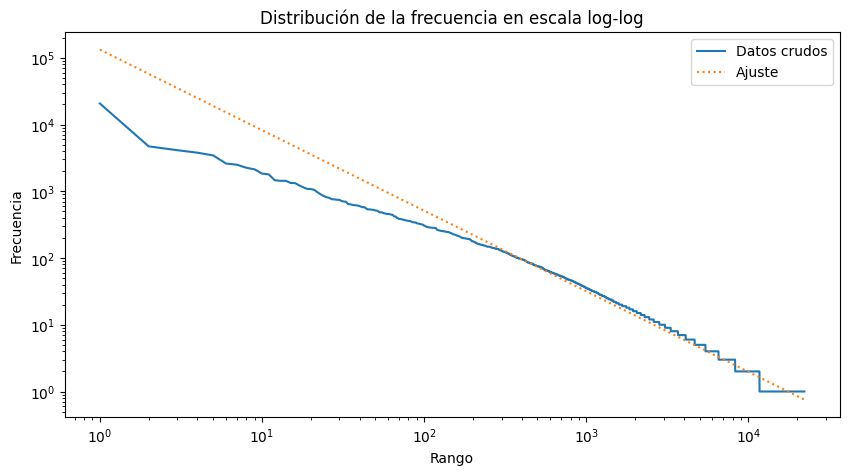

In [6]:
# Graficar los datos y el ajuste en escala log-log
plt.figure(figsize=(10, 5))
plt.loglog(rank, frequencies, label='Datos crudos')
plt.loglog(rank, np.exp(fit(log_rank)), label='Ajuste', linestyle='dotted')
plt.xlabel('Rango')
plt.ylabel('Frecuencia')
plt.title('Distribución de la frecuencia en escala log-log')
plt.legend()
plt.show()

In [7]:
total_words = len(sorted_term_freq)
inv_fit = np.poly1d(coefficients)

# Calcular la frecuencia esperada para el 10%, 20% y 30% del vocabulario
percentages = [0.1, 0.2, 0.3]
expected_frequencies = [np.exp(inv_fit(np.log(total_words * p))) for p in percentages]

# Paso 1: Obtener la distribución real de frecuencias de palabras
real_word_freq = [freq for term, freq in sorted_term_freq]

# Paso 2: Ordenar las palabras por frecuencia
real_word_freq_sorted = sorted(real_word_freq, reverse=True)

# Paso 3: Calcular la cantidad de palabras en cada porcentaje del vocabulario
total_unique_words = len(real_word_freq_sorted)
real_words_in_percentages = [real_word_freq_sorted[int(p * total_unique_words)] for p in percentages]

# Paso 4: Comparar con los valores esperados
expected_frequencies = [round(expected) for expected in expected_frequencies]

# Paso 5: Imprimir resultados
print("Porcentaje del vocabulario\t Valor esperado\t Valor real")
for i, p in enumerate(percentages):
    print(f"{p*100}% \t\t\t\t {expected_frequencies[i]}\t\t {real_words_in_percentages[i]}")


Porcentaje del vocabulario	 Valor esperado	 Valor real
10.0% 				 12		 14
20.0% 				 5		 6
30.0% 				 3		 3


In [8]:
pruned_vocab = {}
for p in percentages:
    cutoff = int(len(sorted_term_freq) * p)
    pruned_terms = [term for term, freq in sorted_term_freq[:cutoff]]
    pruned_vocab[p] = pruned_terms

percentage_empty_words = {}
for p, terms in pruned_vocab.items():
    empty_words_count = sum(1 for term in terms if term in stop_words)
    percentage_empty_words[p] = empty_words_count / len(terms) * 100

print("Porcentaje del vocabulario\t Porcentaje de palabras vacías")
for p in percentages:
    print(f"{p*100}% \t\t\t\t {percentage_empty_words[p]}%")


Porcentaje del vocabulario	 Porcentaje de palabras vacías
10.0% 				 5.87437867148667%
20.0% 				 3.207589789925457%
30.0% 				 2.3490438187020026%


In [9]:
important_words = {}
for p, terms in pruned_vocab.items():
    important_words[p] = [term for term in terms if term not in stop_words]
for p, words in important_words.items():
    print(f"Palabras podadas en el {p*100}% del vocabulario que no son stopwords:")
    print(words)


Palabras podadas en el 10.0% del vocabulario que no son stopwords:
['don', 'Quijote', 'Sancho', 'dijo', 'ser', 'hab', 'tan', 'respondi', 'bien', 'merced', 'est', 'dos', 'sino', 'pues', 'aqu', 'caballero', 'decir', 'No', 'ora', 'hacer', 'ver', 'aunque', 'all', 'dar', 'aquel', 'Dios', 'ten', 'mal', 'cosa', 'buen', 'tal', 'verdad', 'mundo', 'alguna', 'dicho', 'parte', 'cosas', 'todas', 'buena', 'vida', 'luego', 'menos', 'lugar', 'ndose', 'ndole', 'casa', 'manera', 'aquella', 'tiempo', 'gran', 'En', 'toda', 'cura', 'ahora', 'puesto', 'mano', 'amo', 'qui', 'dio', 'caballeros', 'dec', 'mejor', 'ojos', 'puede', 'alg', 'Dulcinea', 'visto', 'tierra', 'Sancho Panza', 'pod', 'historia', 'padre', 'hombre', 'hecho', 'haber', 'digo', 'Pero', 'quiero', 'fin', 'cielo', 'aun', 'amigo', 'ven', 'saber', 'vio', 'escudero', 'camino', 'tener', 'lleg', 'podr', 'manos', 'parece', 'muchas', 'hizo', 'tambi', 'El', 'Pues', 'desta', 'tres', 'mujer', 'caballer', 'cuenta', 'De', 'cuanto', 'mesmo', 'cabeza', 'Yo', '

Las palabras podadas que no son stop-words son importantes para la recuperación, debido al contexto en el que nos encontramos, por ejemplo poda 'don', 'Quijote' y 'Sancho'. Tambien nos limita la diversidad de vocabulario lo cual en un texto como éste es crucial, así como también la combinación de palabras o terminos compuestos que resultan en la pérdida del sentido de una frase.